<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/AD_Ad0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Instructions for Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Required Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import itertools

# Setting Random Seeds for Reproducibility in NumPy and TensorFlow

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

> used to make sure that the randomness in NumPy and TensorFlow is consistent across different runs of the program, enabling reproducibility.

In [4]:
# Update the data directory to point to your Google Drive
data_dir = '/content/drive/MyDrive/ADNI'

# Loading Image Data from Directory

In [5]:
# Load data
def load_data(data_dir):
    images, labels = [], []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Loading and One-Hot Encoding Labels for Image Data

In [6]:
images, labels = load_data(data_dir)
labels = np.where(labels == 'AD', 1, 0)
one_hot = np.zeros((labels.shape[0], 2))
one_hot[np.arange(labels.shape[0]), labels] = 1
labels = one_hot

In [7]:
print(labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Splitting Data into Training, Validation, and Test Sets

In [8]:
# Train-validation-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.05, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [9]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1422, 64, 64, 3) (1422, 2)
(158, 64, 64, 3) (158, 2)
(84, 64, 64, 3) (84, 2)


# Visualizing Class Distribution Prior to Augmentation

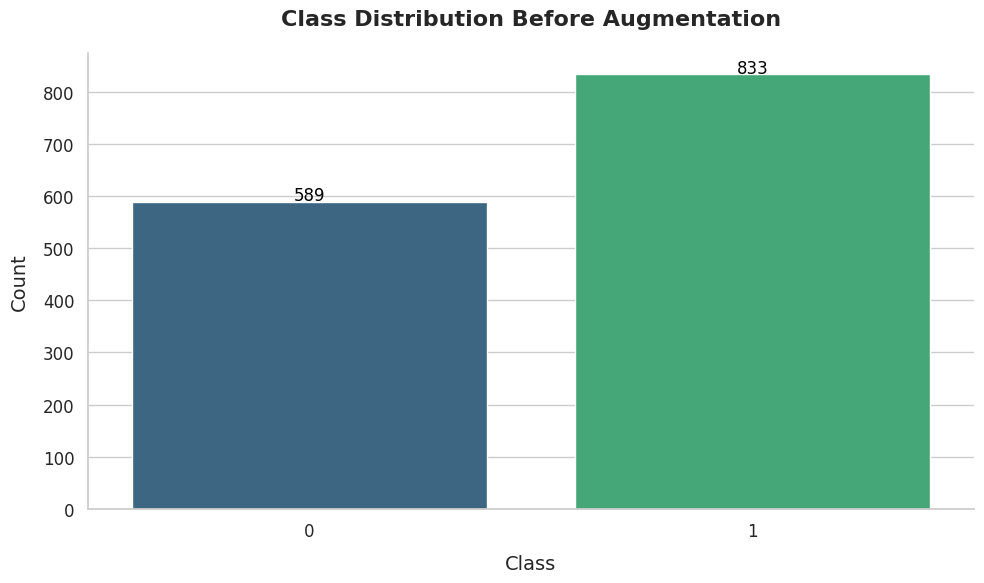

In [10]:
# Set the style for the plot
sns.set(style="whitegrid", palette="pastel")

# Create the countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=np.argmax(y_train, 1), hue=np.argmax(y_train, 1), palette="viridis", legend=False)

# Add title and labels
plt.title('Class Distribution Before Augmentation', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Class', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)

# Customize the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Add data labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')

# Remove the top and right spines
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

# Configure Batch Size for Model Training

In [11]:
batch_size = 64


# Applying Data Augmentation Techniques

In [12]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
train_datagen_test = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
train_generator_test = train_datagen_test.flow(X_train, y_train, batch_size=batch_size)

val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

# Display class distribution after augmentation
augmented_images, _ = next(train_generator)

# Class Distribution After Augmentation

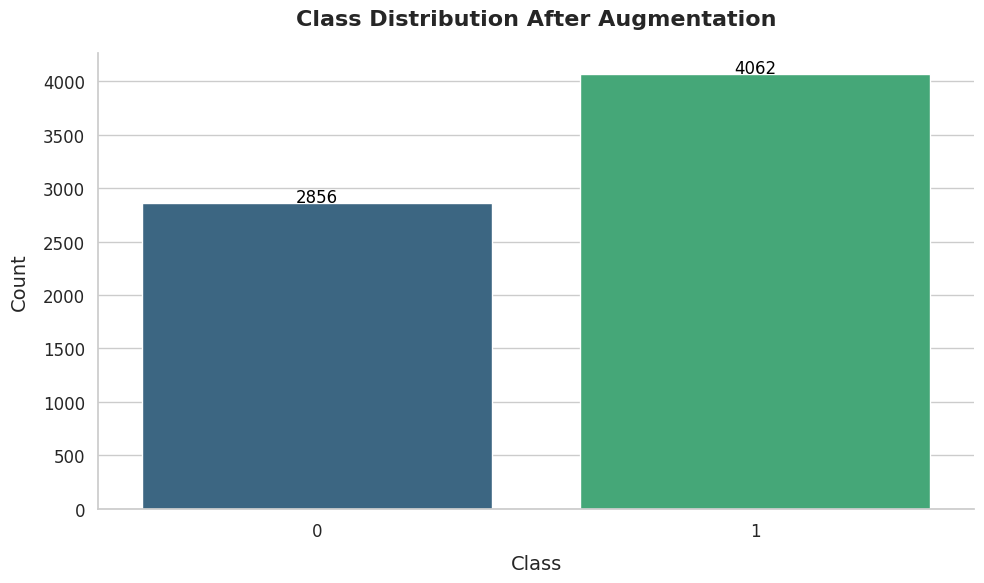

In [16]:
# Generate augmented labels
augmented_labels = []
for _ in range((len(y_train) * 5 // batch_size) + 1):
    _, batch_labels = next(train_generator)
    augmented_labels.extend(batch_labels)

# Convert augmented_labels to a numpy array for easier manipulation
augmented_labels = np.array(augmented_labels)

# Set the style for the plot
sns.set(style="whitegrid", palette="pastel")

# Create the countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=np.argmax(augmented_labels, 1), hue=np.argmax(augmented_labels, 1), palette="viridis", legend=False)

# Add title and labels
plt.title('Class Distribution After Augmentation', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Class', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)

# Customize the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Add data labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')

# Remove the top and right spines
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

# Display 5 Original Images with Labels and 10 Augmented Images

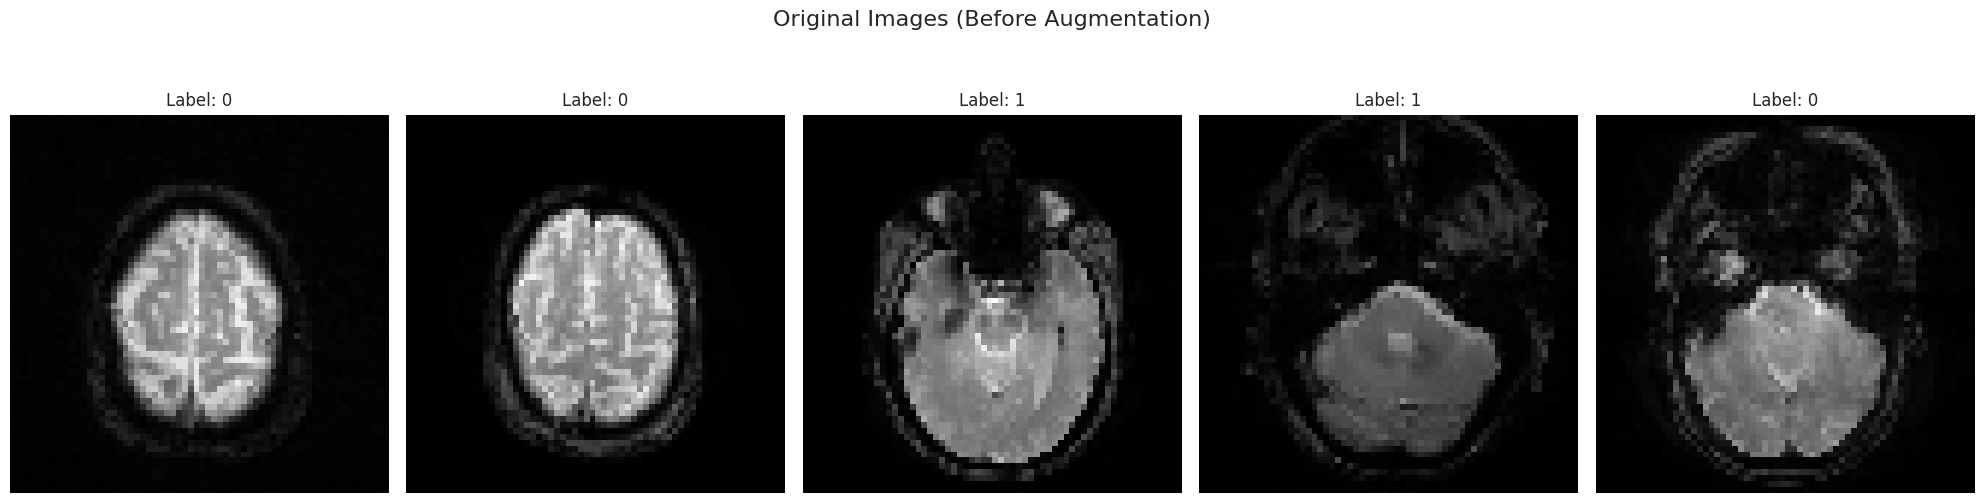

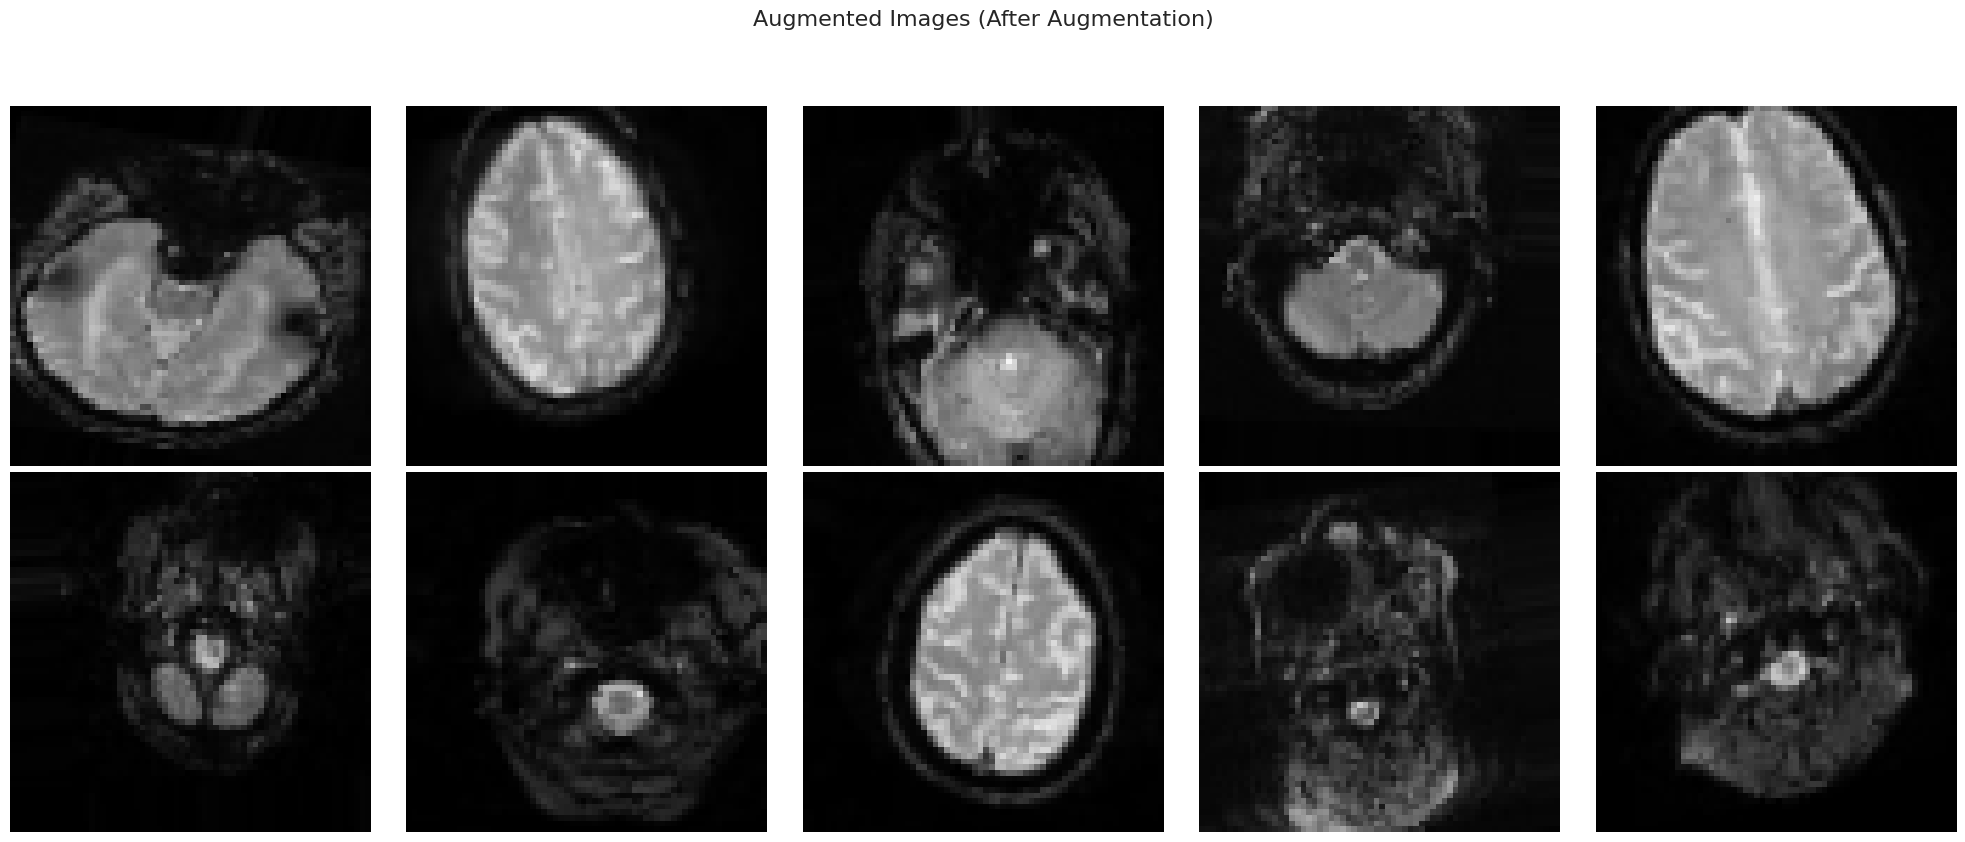

In [20]:
# Display 5 original images with labels
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Original Images (Before Augmentation)', fontsize=16, y=1.05)

for i in range(5):
    random_index = np.random.randint(0, len(X_train))  # Randomly select an image from the training set
    ax = axes[i]
    ax.imshow(X_train[random_index].astype('uint8'))  # Display the original image
    ax.set_title(f'Label: {np.argmax(y_train[random_index])}')  # Show the corresponding label
    ax.axis('off')

plt.tight_layout()
plt.show()

# Display 10 augmented images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns for 10 images
fig.suptitle('Augmented Images (After Augmentation)', fontsize=16, y=1.05)

for i in range(10):
    random_index = np.random.randint(0, len(augmented_images))  # Randomly select an augmented image
    ax = axes[i // 5, i % 5]  # Arrange images in 2 rows and 5 columns
    ax.imshow(augmented_images[random_index])  # Display the augmented image
    ax.axis('off')

plt.tight_layout()
plt.show()

# Models Definitions


In [24]:
# Define models
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 26, 26, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │       1,384,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,458,530 (5.56 MB)

 Trainable params: 1,458,530 (5.56 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,410 (6.20 MB)

 Trainable params: 1,625,410 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       3,686,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,705,058 (14.13 MB)

 Trainable params: 3,705,058 (14.13 MB)

 Non-trainable params: 0 (0.00 B)

## Create a Dictionary Named models to Store Three Different Keras Models

In [30]:
models = {
    "Model 1": model1,
    "Model 2": model2,
    "Model 3": model3
}

## Define the Checkpoint Configuration


In [31]:
# Define the checkpoint directory in Google Drive
checkpoint_dir = '/content/drive/MyDrive/chksAD'

# Create the directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Define the checkpoint path
checkpoint_path = os.path.join(checkpoint_dir, 'best_model.keras')

# Set up the ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Save only the best model
    monitor='val_loss',    # Monitor validation loss
    mode='min',            # Minimize validation loss
    verbose=1              # Print a message when saving the model
)


# Define Compile and Train Functions


In [32]:
def compile_and_train(model, train_generator, val_generator, checkpoint_callback, epochs=100):
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=val_generator,
                        callbacks=[checkpoint_callback])
    return history

# Define Function to Plot Training History


In [33]:
def plot_history(name, history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(name)
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.show()

# Evaluate and Plot Confusion Matrix

In [36]:
def evaluate_and_plot_confusion_matrix(name, model, generator, y, class_names=None, save_plots=False):
    # Evaluate the model
    test_loss, test_acc = model.evaluate(generator)
    print(f"Test accuracy: {test_acc}", f"Test loss: {test_loss}")

    # Extract true labels
    Y_true = []
    generator.reset()
    for _ in range((len(y) // batch_size) + 1):
        _, batch_labels = next(generator)
        Y_true.extend(batch_labels)
    Y_true = np.argmax(Y_true, 1)

    # Generate predictions
    generator.reset()
    Y_pred = model.predict(generator)
    Y_pred_classes = np.argmax(Y_pred, 1)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(Y_true, Y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name + ' Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    if save_plots:
        plt.savefig(os.path.join(checkpoint_dir, f'{name}_ROC_Curve.png'))
    plt.show()

    # Plot confusion matrix
    conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(name + ' Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names)) if class_names else np.arange(2)
    plt.xticks(tick_marks, class_names if class_names else ['Class 0', 'Class 1'], rotation=45)
    plt.yticks(tick_marks, class_names if class_names else ['Class 0', 'Class 1'])
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(checkpoint_dir, f'{name}_Confusion_Matrix.png'))
    plt.show()

    # Compute and print metrics
    accuracy = accuracy_score(Y_true, Y_pred_classes)
    precision = precision_score(Y_true, Y_pred_classes)
    recall = recall_score(Y_true, Y_pred_classes)
    f1 = f1_score(Y_true, Y_pred_classes)
    print(f'Accuracy: {accuracy*100:.2f}')
    print(f'Precision: {precision*100:.2f}')
    print(f'Recall: {recall*100:.2f}')
    print(f'F1 Score: {f1:.3f}')
    print(f'AUC: {roc_auc:.3f}')
    print(f"Loss: {test_loss:.3f}")

# Training and Evaluation Pipeline


Training Model 1...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.5460 - loss: 0.6802
Epoch 1: val_loss improved from inf to 0.68233, saving model to /content/drive/MyDrive/chksAD/best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 416ms/step - accuracy: 0.5454 - loss: 0.6814 - val_accuracy: 0.5886 - val_loss: 0.6823
Epoch 2/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5794 - loss: 0.6768
Epoch 2: val_loss improved from 0.68233 to 0.64637, saving model to /content/drive/MyDrive/chksAD/best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5800 - loss: 0.6763 - val_accuracy: 0.5823 - val_loss: 0.6464
Epoch 3/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5603 - loss: 0.6749
Epoch 3: val_loss improved from 0.64637 to 0.64019, saving model to /content/drive/MyDrive/chksAD/best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5630 - loss: 0.6738 - val_accuracy: 0.5886 - val_loss: 0.6402
Epoch 4/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy

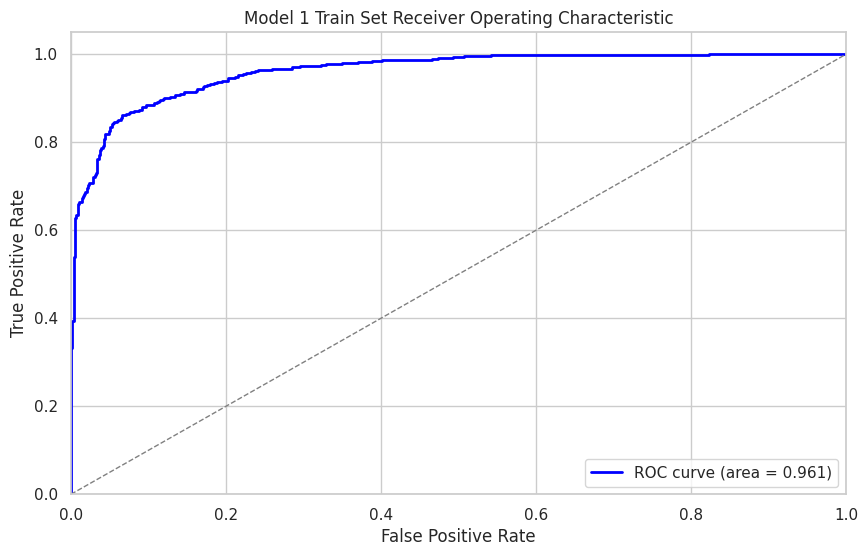

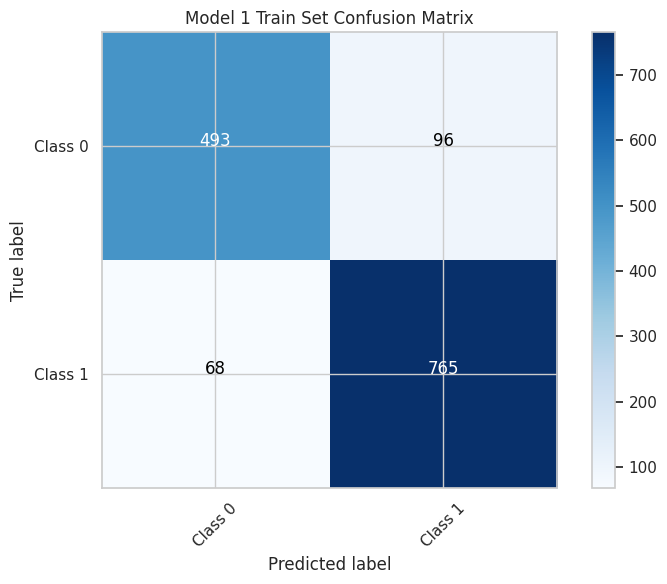

Accuracy: 88.47
Precision: 88.85
Recall: 91.84
F1 Score: 0.903
AUC: 0.961
Loss: 0.252
Evaluating Model 1 on Validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7791 - loss: 0.4054 
Test accuracy: 0.7848101258277893 Test loss: 0.40481850504875183
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


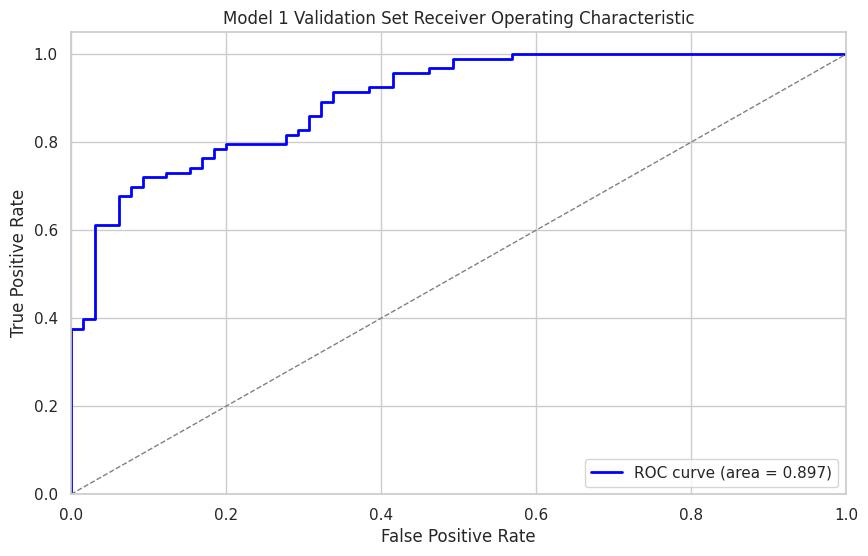

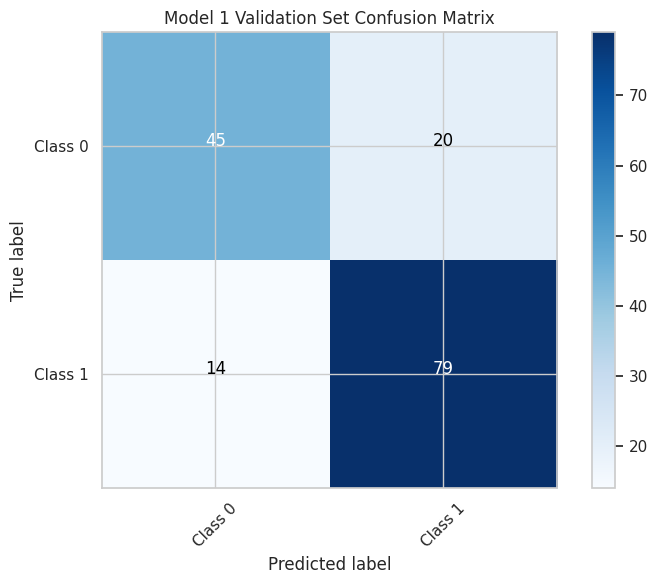

Accuracy: 78.48
Precision: 79.80
Recall: 84.95
F1 Score: 0.823
AUC: 0.897
Loss: 0.405
Evaluating Model 1 on Test set...
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8438 - loss: 0.4159

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8289 - loss: 0.4145
Test accuracy: 0.8214285969734192 Test loss: 0.4137169122695923
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


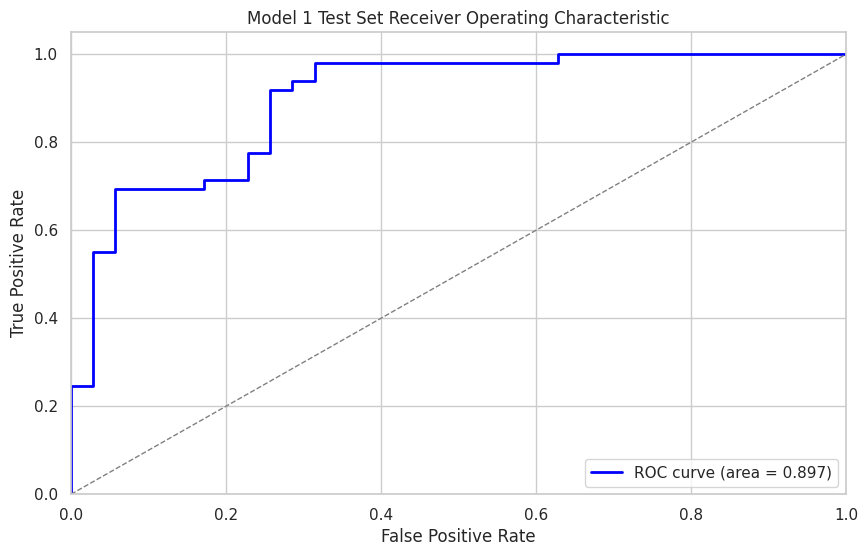

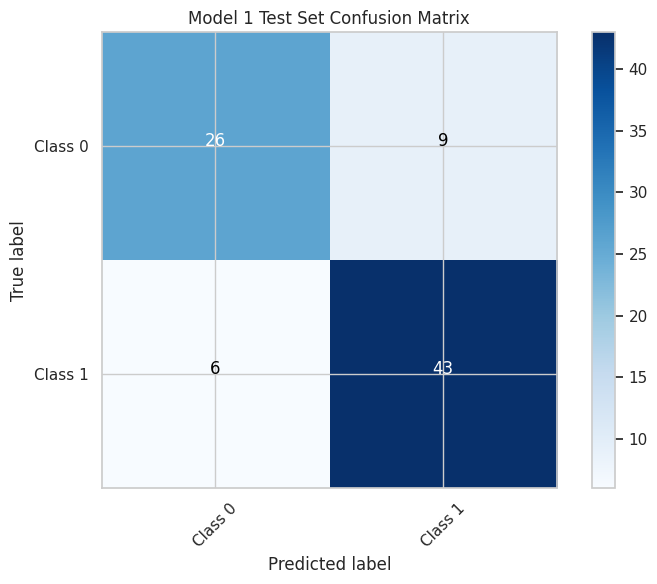

Accuracy: 82.14
Precision: 82.69
Recall: 87.76
F1 Score: 0.851
AUC: 0.897
Loss: 0.414
Plotting history for Model 1...


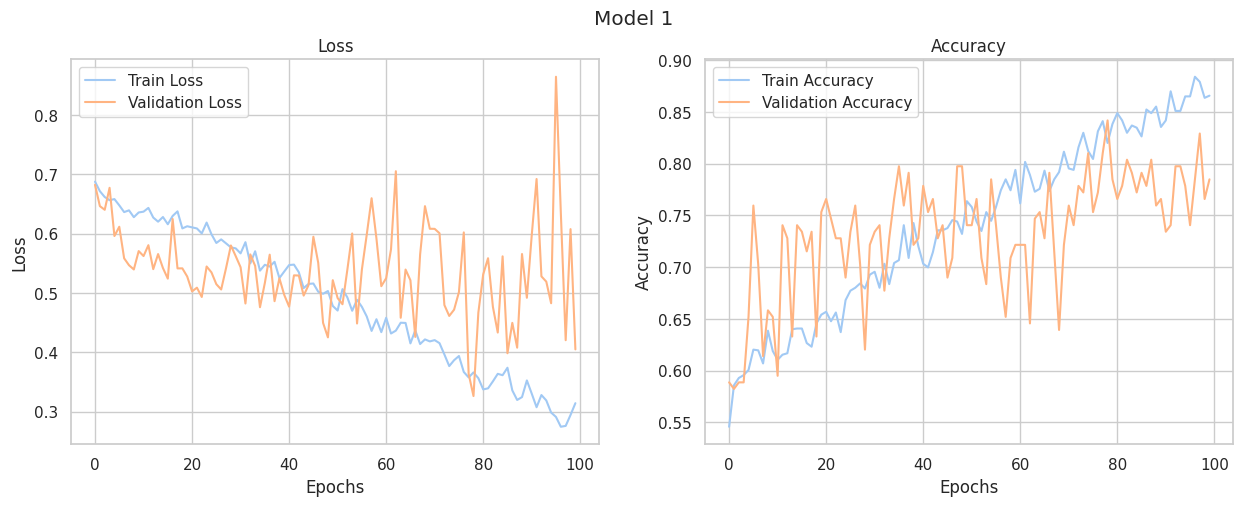

Training Model 2...
Epoch 1/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.4777 - loss: 0.8000
Epoch 1: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.4809 - loss: 0.7942 - val_accuracy: 0.5886 - val_loss: 0.6763
Epoch 2/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5782 - loss: 0.6769
Epoch 2: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5788 - loss: 0.6767 - val_accuracy: 0.5886 - val_loss: 0.6688
Epoch 3/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5532 - loss: 0.6825
Epoch 3: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5559 - loss: 0.6814 - val_accuracy: 0.5886 - val_loss: 0.6735
Epoch 4/100
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5907 - loss: 0.6688
Epoch 4: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.5901 - loss: 0.6675 - val_accuracy: 0.5886 

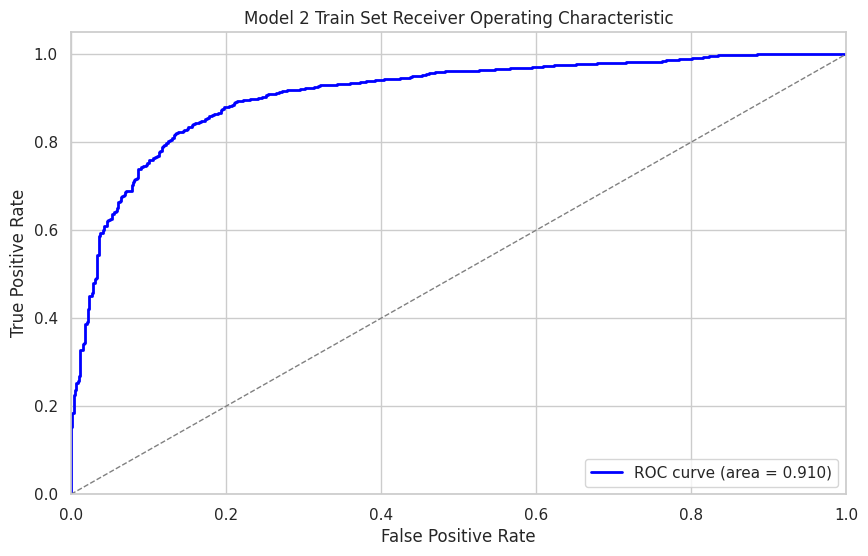

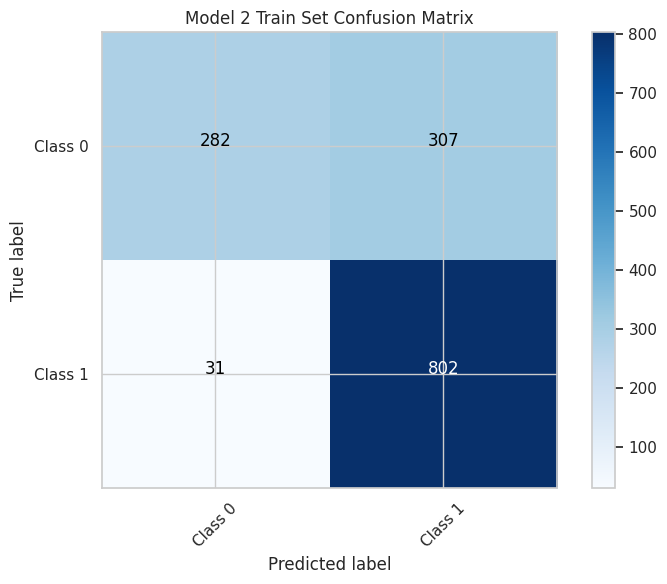

Accuracy: 76.23
Precision: 72.32
Recall: 96.28
F1 Score: 0.826
AUC: 0.910
Loss: 0.480
Evaluating Model 2 on Validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7594 - loss: 0.5237 
Test accuracy: 0.753164529800415 Test loss: 0.5411350727081299
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


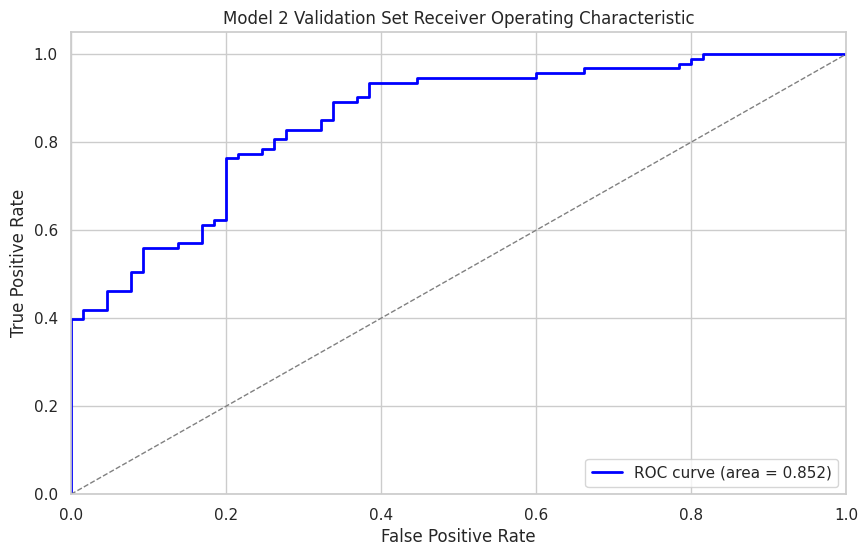

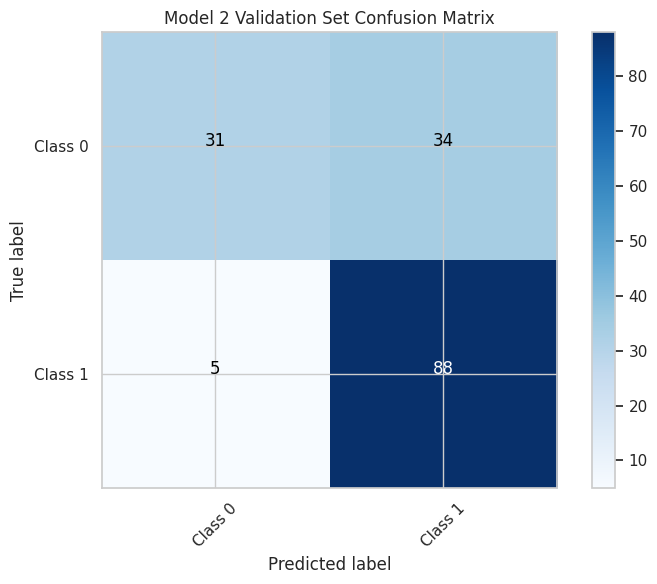

Accuracy: 75.32
Precision: 72.13
Recall: 94.62
F1 Score: 0.819
AUC: 0.852
Loss: 0.541
Evaluating Model 2 on Test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step - accuracy: 0.7237 - loss: 0.7277
Test accuracy: 0.726190447807312 Test loss: 0.72291100025177
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


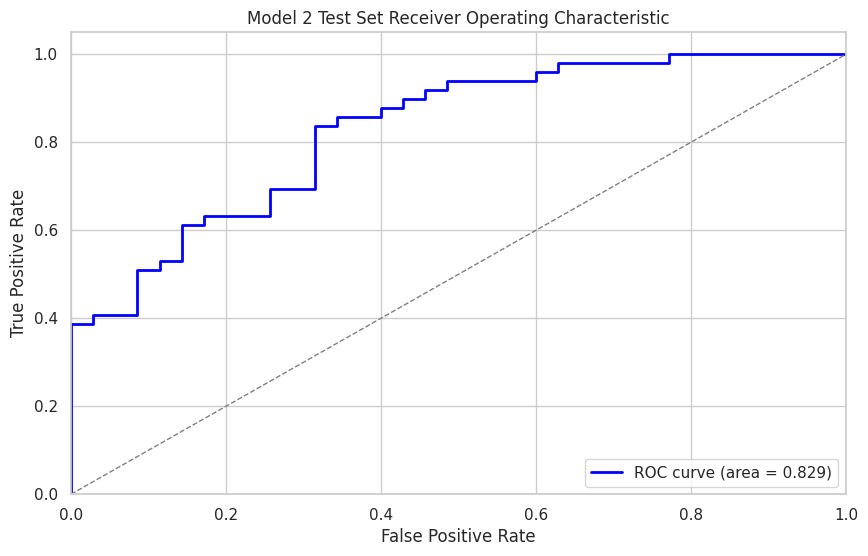

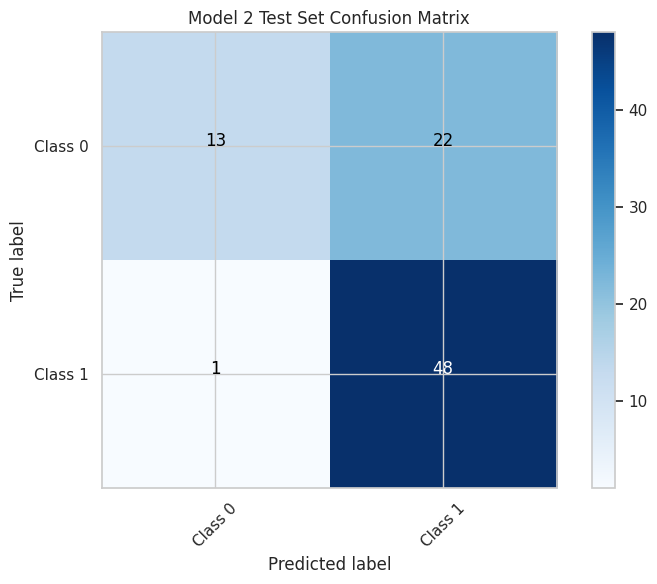

Accuracy: 72.62
Precision: 68.57
Recall: 97.96
F1 Score: 0.807
AUC: 0.829
Loss: 0.723
Plotting history for Model 2...


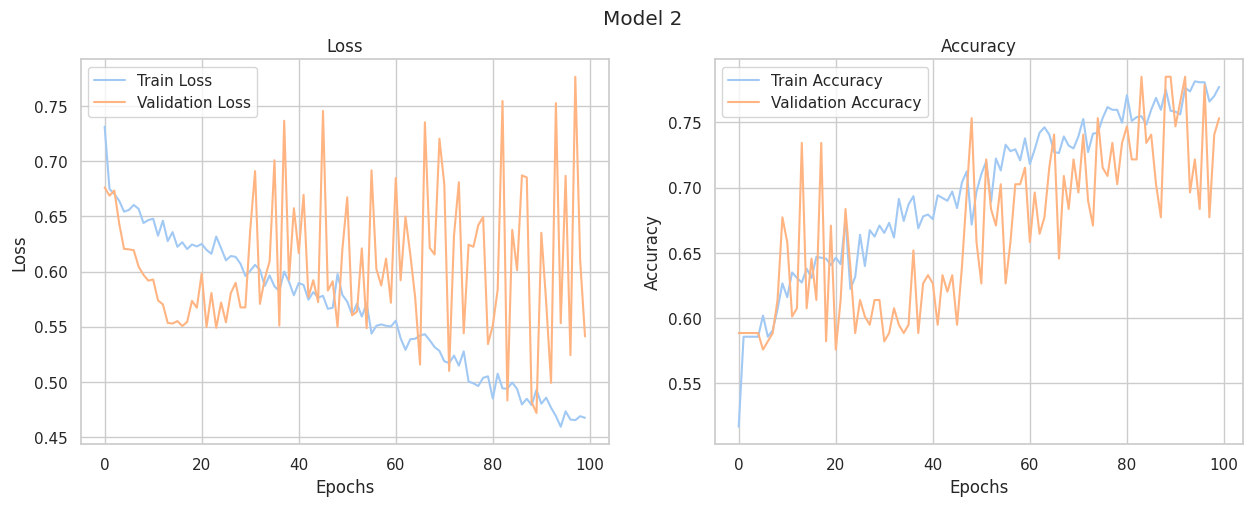

Training Model 3...
Epoch 1/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5025 - loss: 0.7320
Epoch 1: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.5086 - loss: 0.7281 - val_accuracy: 0.5886 - val_loss: 0.6975
Epoch 2/100
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6016 - loss: 0.6632
Epoch 2: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5977 - loss: 0.6644 - val_accuracy: 0.5823 - val_loss: 0.6342
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5984 - loss: 0.6632
Epoch 3: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5980 - loss: 0.6633 - val_accuracy: 0.5886 - val_loss: 0.6150
Epoch 4/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6121 - loss: 0.6335
Epoch 4: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.6129 - loss: 0.6334 - val_accuracy: 0.7468 -

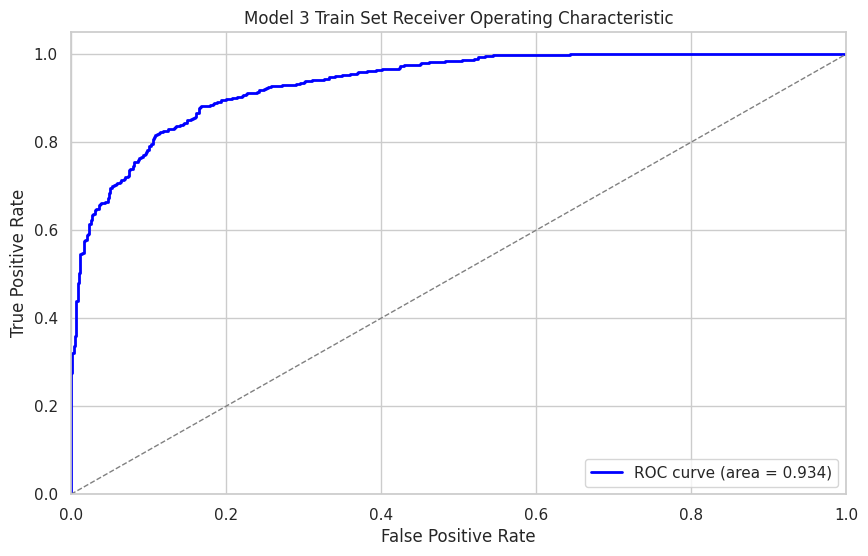

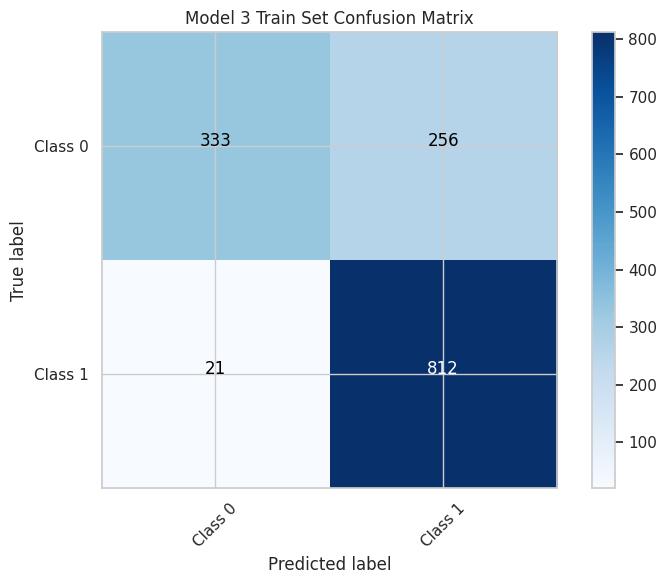

Accuracy: 80.52
Precision: 76.03
Recall: 97.48
F1 Score: 0.854
AUC: 0.934
Loss: 0.409
Evaluating Model 3 on Validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7838 - loss: 0.5236 
Test accuracy: 0.7784810066223145 Test loss: 0.5429726839065552
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


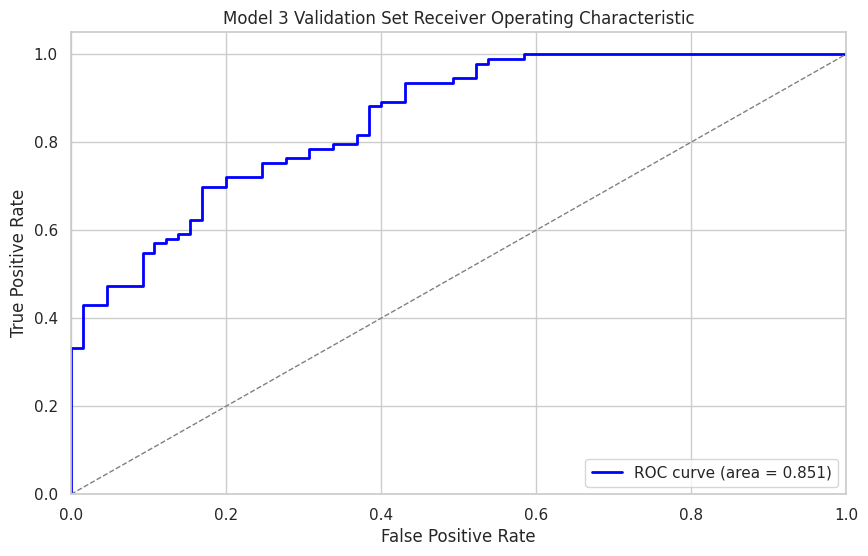

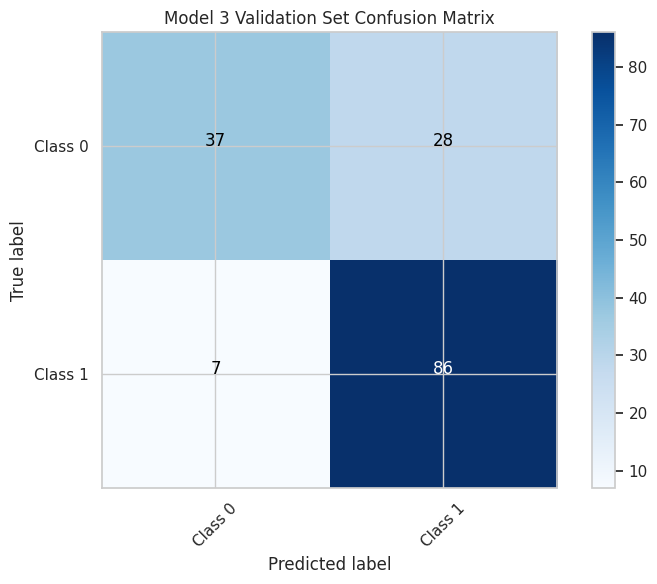

Accuracy: 77.85
Precision: 75.44
Recall: 92.47
F1 Score: 0.831
AUC: 0.851
Loss: 0.543
Evaluating Model 3 on Test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step - accuracy: 0.7316 - loss: 0.6435
Test accuracy: 0.738095223903656 Test loss: 0.6233118772506714
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


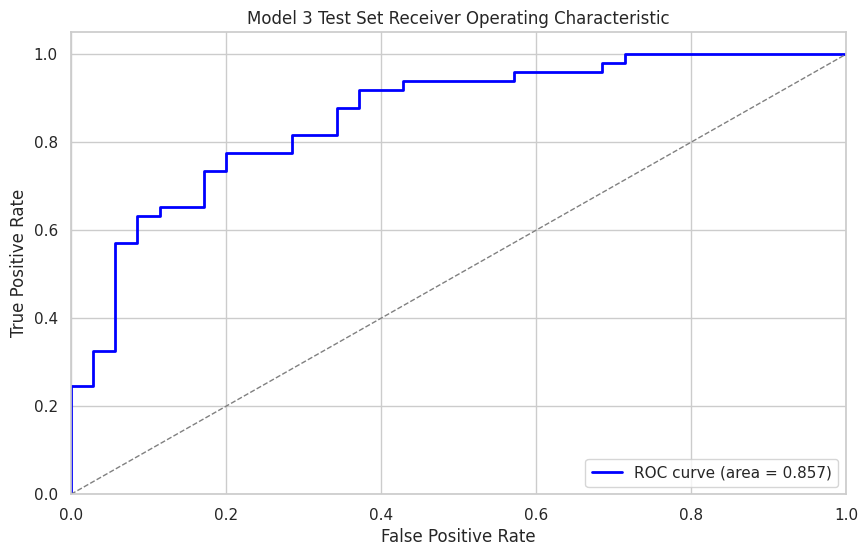

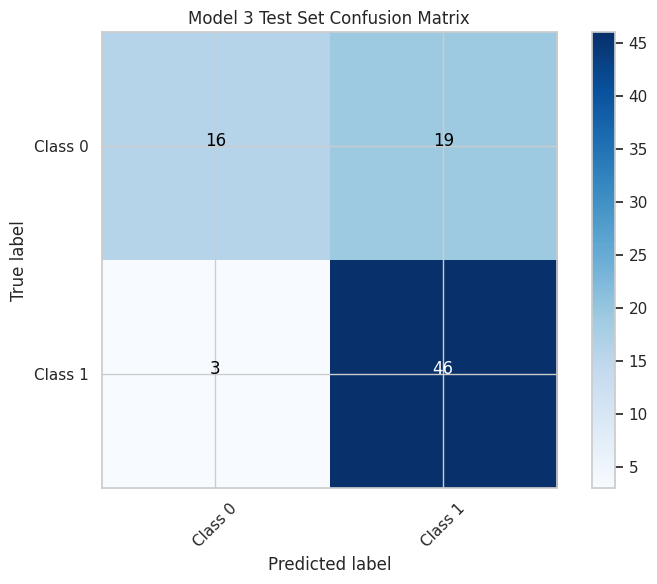

Accuracy: 73.81
Precision: 70.77
Recall: 93.88
F1 Score: 0.807
AUC: 0.857
Loss: 0.623
Plotting history for Model 3...


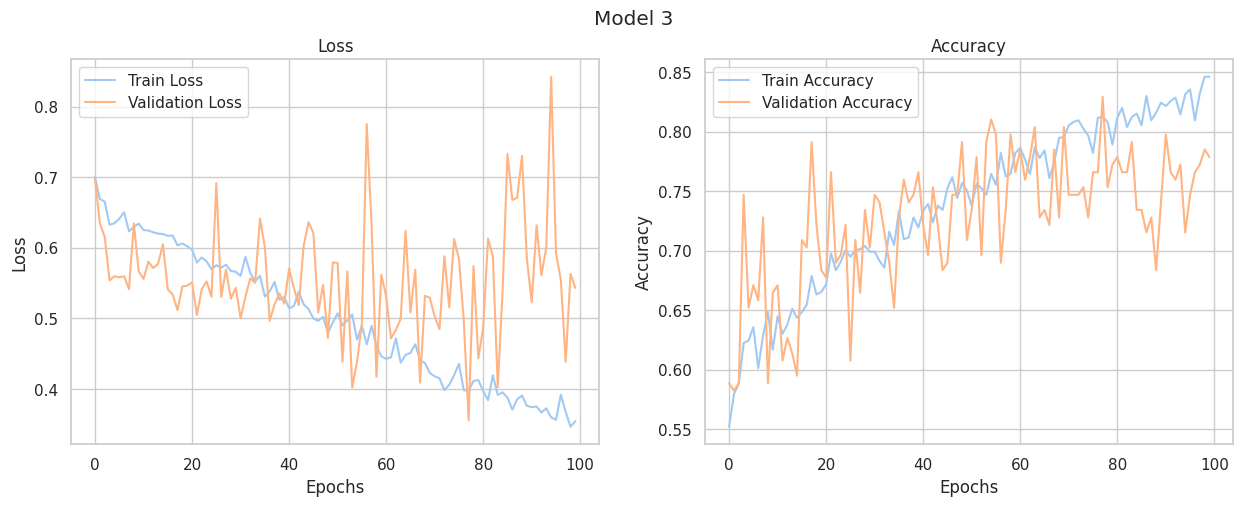

In [37]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    history = compile_and_train(model, train_generator, val_generator, checkpoint_callback)

    print(f"Evaluating {model_name} on Train set...")
    evaluate_and_plot_confusion_matrix(model_name + ' Train Set', model, train_generator_test, y_train)

    print(f"Evaluating {model_name} on Validation set...")
    evaluate_and_plot_confusion_matrix(model_name + ' Validation Set',model, val_generator, y_val)

    print(f"Evaluating {model_name} on Test set...")
    evaluate_and_plot_confusion_matrix(model_name + ' Test Set',model, test_generator, y_test)

    print(f"Plotting history for {model_name}...")
    plot_history(model_name, history)

In [38]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_name = 'Model with DropOut and Glorot Initializer'
print(f"Training {model_name}...")
history = compile_and_train(model, train_generator, val_generator, checkpoint_callback)

print(f"Evaluating {model_name} on Train set...")
evaluate_and_plot_confusion_matrix(model_name + ' Train Set', model, train_generator_test, y_train)

print(f"Evaluating {model_name} on Validation set...")
evaluate_and_plot_confusion_matrix(model_name + ' Validation Set',model, val_generator, y_val)

print(f"Evaluating {model_name} on Test set...")
evaluate_and_plot_confusion_matrix(model_name + ' Test Set',model, test_generator, y_test)

print(f"Plotting history for {model_name}...")
plot_history(model_name, history)

Training Model with DropOut and Glorot Initializer...
Epoch 1/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 2:43 7s/step - accuracy: 0.3281 - loss: 0.7206

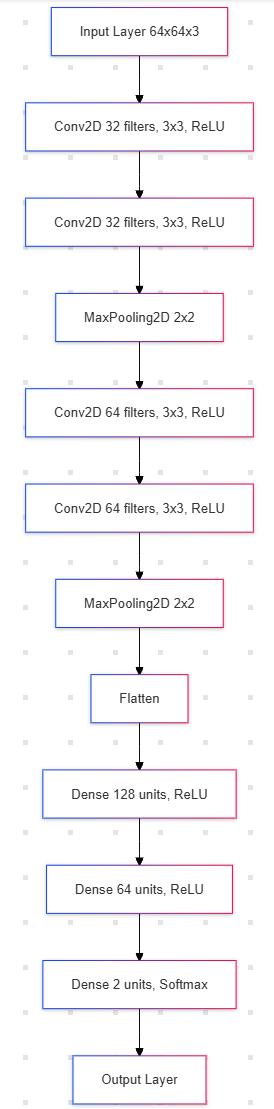